In [1]:
from xgboost import XGBClassifier
import warnings
from tabpfn import TabPFNClassifier
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import torch
import openml
from tabpfn_new.priors import flexible_categorical
from tabpfn_new.priors import mlp


In [2]:
path = "datasets/data_all.csv"
all_data, labels = get_microbiome(path)
all_data = remove_zero_features(all_data)
all_data = (1/np.sum(all_data, axis=1, keepdims=True))*all_data
all_data, labels = unison_shuffled_copies(all_data, labels, seed=42)

In [4]:
print(all_data.shape)

(11462, 1391)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


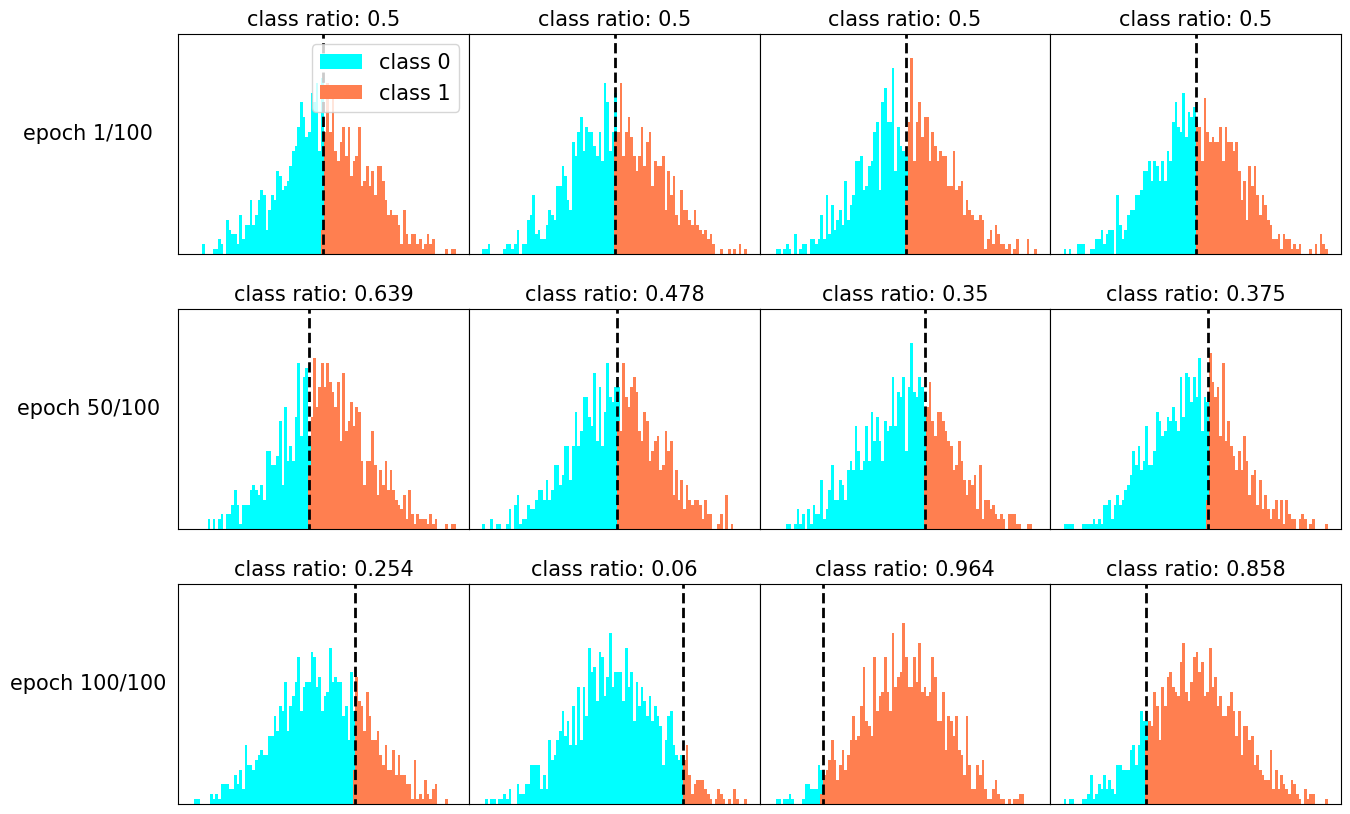

In [82]:
N = 1024+128
maxe = 3
numcol = 4
fig, ax = plt.subplots(3,numcol,gridspec_kw={'hspace': 0.25, 'wspace' : 0}, sharex=True, sharey=True, dpi=100, figsize=(15,10))
names = ["epoch 1/100", "epoch 50/100", "epoch 100/100"]
for e in range(maxe):
    ax[e,0].set_ylabel(names[e], rotation=0, fontsize=15, labelpad=65)
    for i in range(numcol):
        bins = np.linspace(-3,3,101)
        efrac = (e/(maxe-1))
        y = np.random.normal(0,1,(N))
        med = np.median(y)
        s = np.random.normal(med,efrac)
        r = round(np.mean((y>s)*1),3)
        ax[e,i].set_title(f"class ratio: {r}",fontsize=15)
        ax[e,i].vlines(s, -1,45, colors="black", lw=2, linestyles="dashed")
        ax[e,i].set_xticks([])
        ax[e,i].set_yticks([])
        ax[e,i].set_ylim(0,45)
        ax[e,i].hist(y, bins=bins, color="cyan", label="class 0")
        ax[e,i].hist(y[y>s], bins=bins, color="coral", label="class 1")
ax[0,0].legend(fontsize=15)
fig.savefig("results/plots/datasetsplit.eps")

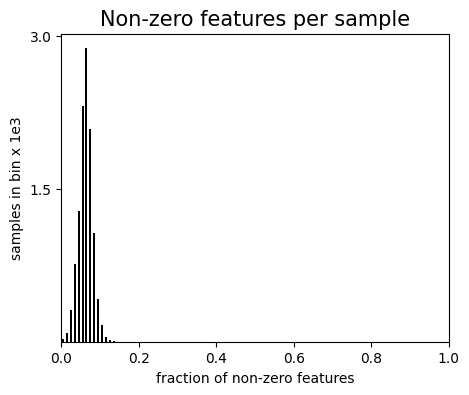

In [219]:
plt.figure(figsize=(5,4), dpi=100)
counts = np.count_nonzero(all_data, axis=1)/all_data.shape[1]
plt.title("Non-zero features per sample", fontsize=15)
plt.ylabel("samples in bin x 1e3")
plt.xlabel("fraction of non-zero features")
plt.xlim(0,1.0)
plt.xticks(fontsize=10)
plt.yticks([1500, 3000], [1.5, 3.0], fontsize=10)
bins = np.linspace(0.0,1.0, 100, endpoint=False)
#print(bins)
_ = plt.hist(counts, bins=bins, color="black", rwidth=0.5)
if not os.path.exists("results/plots"):
    os.makedirs("results/plots")
plt.savefig("results/plots/mb_dataset_hist.eps", bbox_inches="tight")
plt.show()

0.0


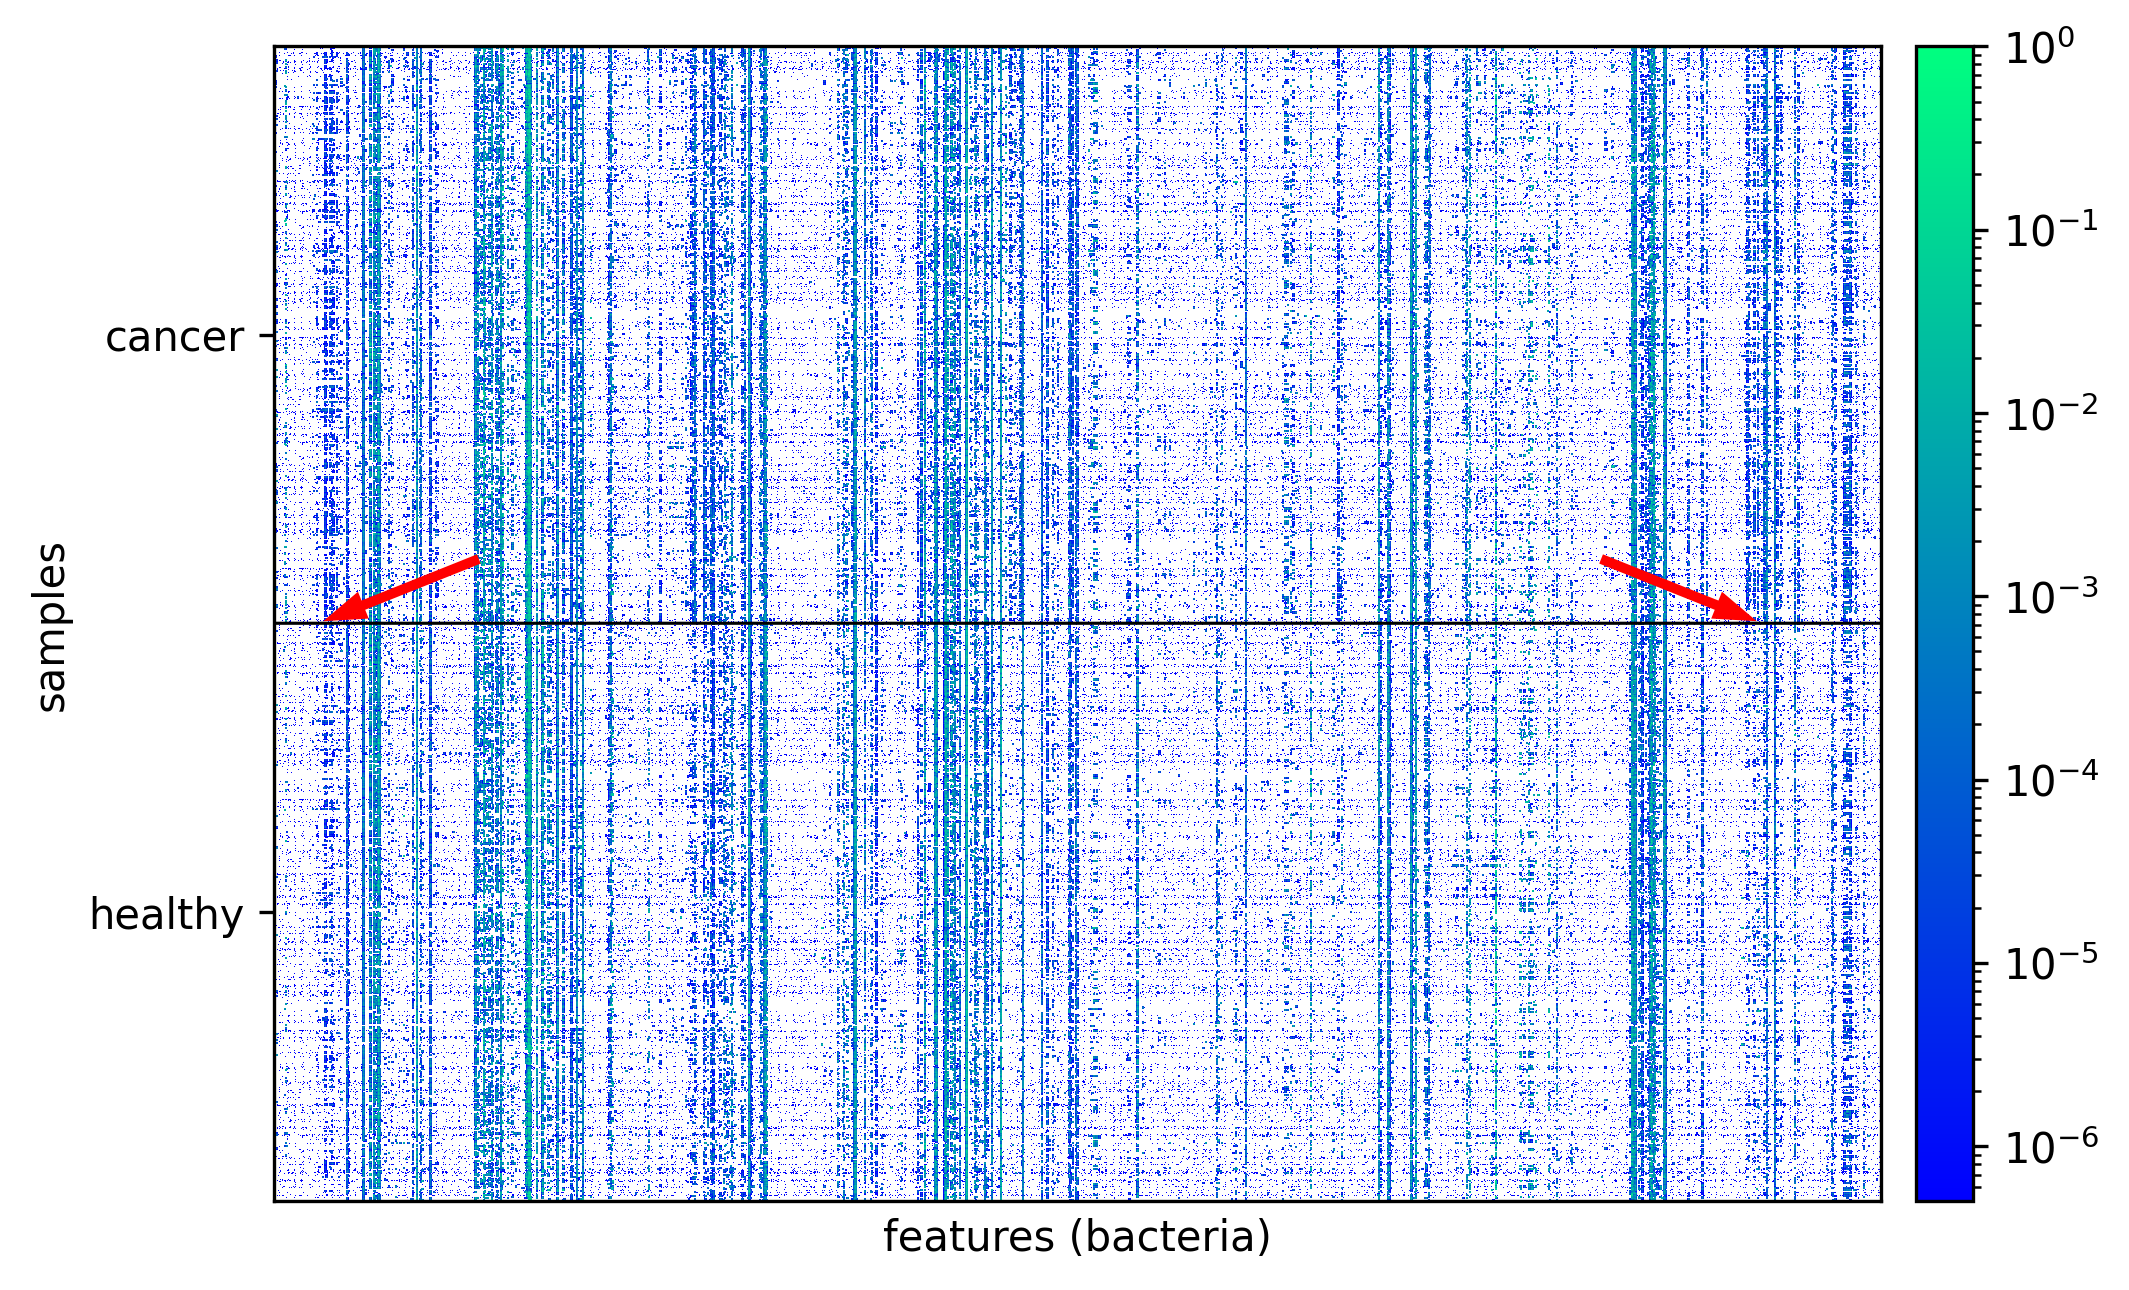

In [220]:
le = 500
wd = all_data.shape[1]
counts = np.count_nonzero(all_data, axis=0)
counts = np.mean(all_data, axis=0)
indices = np.argsort(counts)[::-1]
data = all_data#[:,indices]
data_c0 = data[labels==0]
np.random.shuffle(data_c0)
data_c1 = data[labels==1]
np.random.shuffle(data_c1)
data = np.concatenate((data_c0[:le], data_c1[:le]), axis=0)
print(np.min(data))
'''for c in ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']+['viridis', 'plasma', 'inferno', 'magma', 'cividis']+['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']:'''

plt.figure(figsize=(15,5), dpi=300)
plt.imshow(data[:2*le,:wd], norm=colors.LogNorm(), cmap="winter", origin="lower", aspect="equal")
plt.plot(np.arange(wd), np.ones(wd)*le, c="black", lw=0.75)
y_pos = 515
x_pos = 75
x_len = 100
y_len = 40
plt.arrow(x=x_pos+x_len, y=y_pos+y_len, dx=-x_len, dy=-y_len, color="red", width=5,head_width=20)
y_pos = 515
x_pos = 1250
x_len = -100
y_len = 40
plt.arrow(x=x_pos+x_len, y=y_pos+y_len, dx=-x_len, dy=-y_len, color="red", width=5,head_width=20)
plt.ylabel("samples")
plt.xlabel("features (bacteria)")
plt.yticks([int(le/2),int(le/2)+le], ["healthy", "cancer"])
plt.xticks([])
plt.colorbar(pad=.01)
if not os.path.exists("results/plots"):
    os.makedirs("results/plots")
plt.savefig("results/plots/mb_dataset_overview.eps", bbox_inches="tight")
plt.show()

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


pca = PCA(n_components=2)
pca_data = pca.fit_transform(all_data)
pca_data_c0 = pca_data[labels==0]
pca_data_c1 = pca_data[labels==1]

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(all_data)
tsne_data_c0 = tsne_data[labels==0]
tsne_data_c1 = tsne_data[labels==1]

umap = umap.UMAP(n_components=2)
umap_data = umap.fit_transform(all_data)
umap_data_c0 = umap_data[labels==0]
umap_data_c1 = umap_data[labels==1]

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\lenna\anaconda3\envs\master7\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenna\anaconda3\envs\master7\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\lenna\anaconda3\envs\master7\Lib\subprocess.py", line

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 250x250 with 0 Axes>

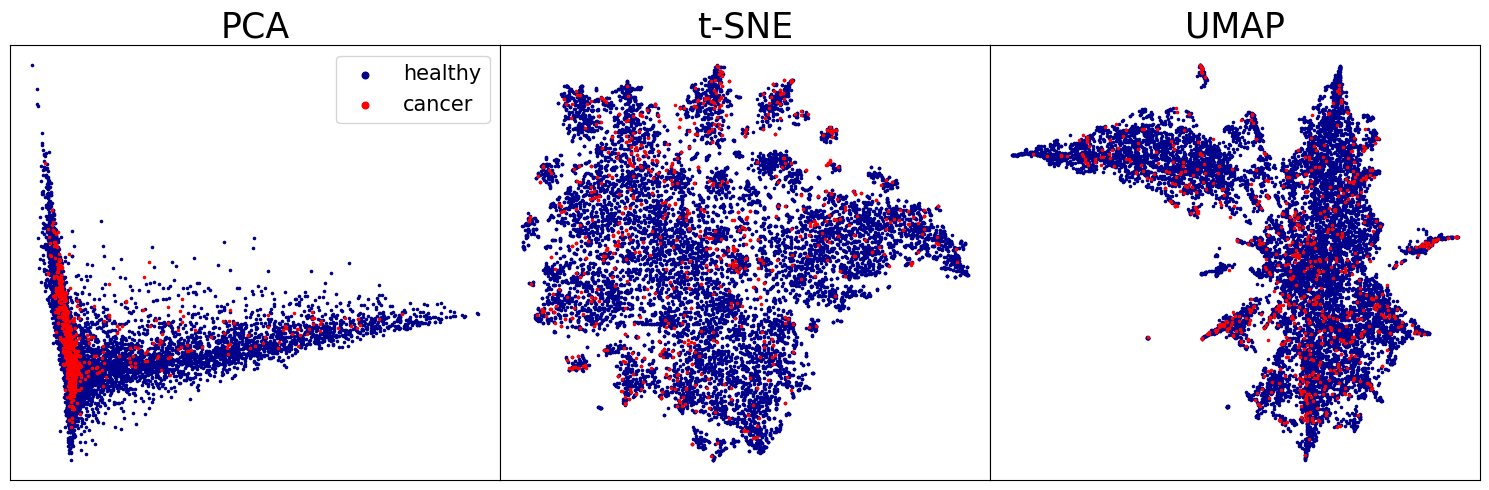

In [221]:
size = 10
c1 = "darkblue"
c2 = "red"
a1 = 1.0
a2 = 1.0
m1 = "."
m2 = "."

plt.figure(figsize=(5,5), dpi=50)
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0}, figsize=(15, 5))

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# First subplot
ax[0].scatter(pca_data_c0[:,0],pca_data_c0[:,1],alpha=a1,s=size, c=c1, label="healthy", marker=m1)
ax[0].scatter(pca_data_c1[:,0],pca_data_c1[:,1],alpha=a2, s=size, c=c2, label="cancer", marker=m2)
ax[0].set_title('PCA', fontsize=25)

# Second subplot
ax[1].scatter(tsne_data_c0[:,0],tsne_data_c0[:,1],alpha=a1, s=size, c=c1, label="healthy", marker=m1)
ax[1].scatter(tsne_data_c1[:,0],tsne_data_c1[:,1],alpha=a2, s=size, c=c2, label="cancer", marker=m2)
ax[1].set_title('t-SNE', fontsize=25)

# Third subplot
ax[2].scatter(umap_data_c0[:,0],umap_data_c0[:,1],alpha=a1, s=size, c=c1, label="healthy", marker=m1)
ax[2].scatter(umap_data_c1[:,0],umap_data_c1[:,1],alpha=a2, s=size, c=c2, label="cancer", marker=m2)
ax[2].set_title('UMAP', fontsize=25)

ax[0].legend(loc="upper right", markerscale=3.0, fontsize=15)
# Display the plots
plt.tight_layout()  # Optional, to prevent overlapping of subplots

plt.savefig("results/plots/mb_dataset_dimreds.eps", bbox_inches="tight")
plt.show()

# Data description

* rows: patients?
* columns: index, identifier, 1650 x bacteria data: $(b_1,...,b_{1650})$, subject_id, disease, country, gender, age_category
* $b_{ij} \in [0,100]$, bacteria values are between 0 and 100
* $\sum\limits_{j=1}^{1650}b_{ij} = 100 \qquad \forall i$ bacteria values of each row sum up to 100 $\Rightarrow$ likely % of total gut biome
* usually only ~100 entries non-zero

In [16]:
df = pd.read_csv(path)
df

,Unnamed: 0,index,s__Abiotrophia_defectiva,s__Abiotrophia_sp_HMSC24B09,s__Absiella_dolichum,s__Acetatifactor_muris,s__Acetivibrio_ethanolgignens,s__Acetomicrobium_flavidum,s__Acholeplasma_oculi,s__Achromobacter_denitrificans,...,s__Xanthomonas_phaseoli,s__Yersinia_enterocolitica,s__Yersinia_frederiksenii,s__Yokenella_regensburgei,s__Zymomonas_mobilis,subject_id,disease,country,gender,age_category
0,0,D_1118_R4_010202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,D_1118_R4_010202,healthy,ITA,NaN,adult
1,1,D_2646_R5_290108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,D_2646_R5_290108,healthy,ITA,NaN,adult
2,2,D_3185_R2_160304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,D_3185_R2_160304,healthy,ITA,NaN,adult
3,3,D_3313_R0_230300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,D_3313_R0_230300,healthy,ITA,NaN,adult
4,4,D_5120_R1_200409-R4_041017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,D_5120_R1_200409-R4_041017,healthy,ITA,NaN,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14555,14555,G104706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,G104706,healthy,FIN,female,adult
14556,14556,G104708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,G104708,healthy,FIN,female,adult
14557,14557,G104709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,G104709,healthy,FIN,female,adult
14558,14558,G104711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,G104711,healthy,FIN,female,adult


In [ ]:
df_binary = df.loc[(df["disease"] == "healthy") | (df["disease"]=="CRC")]

In [ ]:
df_binary["disease"].value_counts()

In [ ]:
# create df of only data and reduce it to 100 columns with least zeros, create df of binary labels with only healthy/CRC
df_binary = df.loc[(df["disease"] == "healthy") | (df["disease"]=="CRC")]
df_data = df_binary.iloc[:,2:-5]
data = df_data.to_numpy()
df_labels = df_binary["disease"]
labels = pd.factorize(df_labels)[0]
data_reduced = top_non_zero(data)
data_healthy = data_reduced[labels==0]
data_crc = data_reduced[labels==1]

np.random.shuffle(data_healthy)
np.random.shuffle(data_crc)
data_crc_oversampled = oversample(data_crc, data_healthy)

data_healthy_undersampled = data_healthy[:data_crc.shape[0]-200,:]


X_oversampled = np.concatenate((data_healthy, data_crc_oversampled), axis=0)
X_undersampled = np.concatenate((data_healthy_undersampled, data_crc), axis=0)
y_oversampled = np.concatenate((np.zeros((data_healthy.shape[0],1)), np.ones((data_crc_oversampled.shape[0],1))))
y_undersampled = np.concatenate((np.zeros((data_healthy_undersampled.shape[0],1)), np.ones((data_crc.shape[0],1))))

X_oversampled, y_oversampled = unison_shuffled_copies(X_oversampled, y_oversampled)
X_undersampled, y_undersampled = unison_shuffled_copies(X_undersampled, y_undersampled)

In [ ]:
xgb = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=0.1, objective='binary:logistic')
xgb_score = cross_validate(xgb, X_oversampled, y_oversampled, scoring=["accuracy", "precision"], cv=20)
print(xgb_score["test_accuracy"].mean())

xgb = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=0.1, objective='binary:logistic')
xgb_score = cross_validate(xgb, X_undersampled, y_undersampled, scoring=["accuracy", "precision"], cv=20)
print(xgb_score["test_accuracy"].mean())

tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=3)
tabpfn_score = cross_validate(tabpfn, X_oversampled, y_oversampled, scoring=["accuracy", "precision"], cv=20)
print(tabpfn_score["test_accuracy"].mean())

tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=3)
tabpfn_score = cross_validate(tabpfn, X_undersampled, y_undersampled, scoring=["accuracy", "precision"], cv=20)
print(tabpfn_score["test_accuracy"].mean())

In [ ]:
xgb = XGBClassifier(n_estimators=10, max_depth=10, learning_rate=0.1, objective='binary:logistic')
train_size = 900
test_size = 100
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, train_size=train_size, test_size=test_size, random_state=42)
xgb.fit(X_train, y_train)
preds = np.expand_dims(xgb.predict(X_test), axis=1)
acc = np.sum((preds==y_test).astype(int))/len(preds)
pre = np.sum(preds.astype(int)*(preds==y_test).astype(int))/int(np.sum(y_test))
print(acc)
print(pre)
tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=3)
tabpfn.fit(X_train, y_train)
preds = np.expand_dims(tabpfn.predict(X_test), axis=1)
acc = np.sum((preds==y_test).astype(int))/len(preds)#
pre = np.sum(preds.astype(int)*(preds==y_test).astype(int))/int(np.sum(y_test))
print(acc)
print(pre)

In [ ]:
dataset = openml.datasets.get_dataset(3, download_data=True, download_qualities=True, download_features_meta_data=True)
data_df = dataset.get_data()[0]
print(dataset.description)
print((data_df.head))

In [ ]:
# create df of only data and reduce it to 100 columns with least zeros, create df of binary labels with only healthy/CRC
df_binary = df.loc[(df["disease"] == "healthy") | (df["disease"]=="CRC")]
df_data = df_binary.iloc[:,2:-5]
df_data.fillna(0).astype(bool).sum(axis=1)
non_zero_counts = df_data.astype(bool).sum(axis=0).to_numpy()
indices = np.argsort(non_zero_counts)[::-1]
df_data_sorted = df_data.iloc[:,indices]
df_labels = df_binary["disease"]
#df_binary = pd.concat([df_data, df_labels], axis=1)

In [ ]:
df_labels.value_counts()

In [ ]:
def get_train_test(data_c0, data_c1, train_size=1000, test_size=100, class_split=0.5):
    c0_mixed, c1_mixed = data_c0.copy(), data_c1.copy()
    np.random.shuffle(c0_mixed)
    np.random.shuffle(c1_mixed)
    train_split = round(train_size*class_split)
    test_split = round(test_size*class_split)
    train_data = np.concatenate((c0_mixed[:train_split], c1_mixed[:train_size-train_split]), axis=0)
    train_labels = np.concatenate((np.zeros(train_split), np.ones(train_size-train_split)), axis=0)
    test_data = np.concatenate((c0_mixed[:test_split], c1_mixed[:test_size-test_split]), axis=0)
    test_labels = np.concatenate((np.zeros(test_split), np.ones(test_size-test_split)), axis=0)
    return train_data, test_data, train_labels, test_labels

In [ ]:
### XGBOOST ###
def XGB_pred(X_train, X_test, y_train, y_test):
    xgb = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    acc = np.sum((preds==y_test).astype(int))/len(preds)
    pre = np.sum(preds.astype(int)*(preds==y_test).astype(int))/int(np.sum(y_test))
    return acc, pre

In [ ]:
### TabPFN ###
def TabPFN_pred(X_train, X_test, y_train, y_test):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=1)
        tabpfn.fit(X_train, y_train)
        preds = tabpfn.predict(X_test)
    acc = np.sum((preds==y_test).astype(int))/len(preds)
    pre = np.sum(preds.astype(int)*(preds==y_test).astype(int))/int(np.sum(y_test))
    return acc, pre

In [ ]:
train_size=500
test_size=100

data_reduced = df_data_sorted.to_numpy()[:,:100]
labels = pd.factorize(df_labels)[0]
#np.random.shuffle(labels)
# split data into classes
data_healthy = data_reduced[labels==0]
data_crc = data_reduced[labels==1]
data_crc = data_crc[:500,:]
#np.random.shuffle(data_healthy)
data_healthy = data_healthy[:data_crc.shape[0],:]
print(data_healthy.shape)
X = np.concatenate((data_healthy, data_crc), axis=0)
print(X.shape)
y = np.concatenate((np.zeros(data_healthy.shape[0]), np.ones(data_crc.shape[0])))
#np.random.shuffle(y)
#X_train, X_test, y_train, y_test = get_train_test(data_healthy, data_crc, train_size=100, class_split=0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
xgb_acc, xgb_pre = XGB_pred(X_train, X_test, y_train, y_test)
tab_acc, tab_pre = TabPFN_pred(X_train, X_test, y_train, y_test)
print("XGB accuracy: ", xgb_acc, "\nXGB precision: ", xgb_pre)

print("TabPFN accuracy: ", tab_acc, "\nTabPFN precision: ", tab_pre)

In [ ]:
tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=1)
tabpfn_score = cross_validate(tabpfn, X, y, scoring=["accuracy", "precision"])
xgb = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')
xgb_score = cross_validate(xgb, X, y, scoring=["accuracy", "precision"])

In [ ]:
print(tabpfn_score["test_accuracy"].mean())
print(xgb_score["test_accuracy"].mean())

In [ ]:
### Test performance for increasingly less important features ###
# data to arrays
torch.set_warn_always(False)
warnings.filterwarnings("ignore")
xgb_accs = []
tab_accs = []
repeats = 10
for shift in range(0,1500,1):
    data_reduced = df_data_sorted.to_numpy()[:,shift:shift+100]
    labels = pd.factorize(df_labels)[0]
    # split data into classes
    data_healthy = data_reduced[labels==0]
    data_crc = data_reduced[labels==1]
    xgb_sum = 0
    tab_sum = 0
    for i in range(repeats):
        X_train, X_test, y_train, y_test = get_train_test(data_healthy, data_crc, class_split=0.5)
        xgb_sum += XGB_pred(X_train, X_test, y_train, y_test)
        tab_sum += TabPFN_pred(X_train, X_test, y_train, y_test)
    xgb_accs.append(xgb_sum/repeats)
    tab_accs.append(tab_sum/repeats)
plt.plot(xgb_accs, label="xgb", linewidth=0.5)
plt.plot(tab_accs, label="tabpfn", linewidth=0.5)
plt.legend()

In [ ]:
plt.plot(xgb_accs, label="xgb", linewidth=0.5)
plt.plot(tab_accs, label="tabpfn", linewidth=0.5)
plt.legend()

In [ ]:
for i in range(100):
    row = df.iloc[i,2:-5]
    col = df.iloc[:,i]
    print(14560-(col==0).astype(int).sum())
    

In [ ]:
df["disease"].value_counts()

In [ ]:
labels = df.iloc[:,-4]
classes, labels = pd.factorize(labels)
print(np.unique(classes))

In [ ]:
pca = PCA(n_components=2)
pca.fit(data)
data_t = pca.transform(data)

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
for c in np.unique(classes):
    ind = (classes==c).nonzero()
    plt.scatter(data_t[ind,0], data_t[ind,1], s = 5, alpha=0.5, label=c)
plt.legend()

In [ ]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(data)

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
for c in np.unique(classes):
    ind = (classes==c).nonzero()
    plt.scatter(embedding[ind,0], embedding[ind,1], s = 5, alpha=0.5, label=c)
plt.legend()